In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install -q seaborn colorama tld plotly whois wordcloud gensim nltk tldextract hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.2/97.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 20.3 MB/s eta 0:00:00


<div style="background-color:blue; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:black;"> <b> 0. Import dependencies</b></div>

In [ ]:
import tldextract
import hashlib
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
from sklearn.pipeline import Pipeline
from datetime import datetime
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier


In [ ]:
urls_data = pd.read_csv('/content/drive/MyDrive/DATASET/malicious_data.csv')
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


<div style="background-color:blue; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:black;"> <b> 1. Data Preparation and EDA</b></div>

In [ ]:
urls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
urls_data.shape

(651191, 2)

In [ ]:
urls_data.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
count = urls_data['type'].value_counts()

colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D'
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])

fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)


fig.update_xaxes(tickfont=dict(color='white'))


fig.update_yaxes(tickfont=dict(color='white'))

fig.show()

In [ ]:
urls_data["type"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
urls_data["url_type"] = urls_data["type"].replace({
    'benign':0,
    'defacement':1,
    'phishing':2,
    'malware':3
});

In [ ]:
urls_data.head()

,url,type,url_type
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [ ]:
def get_url_length(url):
    return len(url)
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
urls_data['url_len'] = urls_data['url'].apply(lambda x: get_url_length(str(x)))

urls_data['pri_domain'] = urls_data['url'].apply(lambda x: extract_pri_domain(x))

In [ ]:
urls_data.head()

,url,type,url_type,url_len,pri_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,www.garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [ ]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

urls_data['letters_count'] =urls_data['url'].apply(lambda x: count_letters(x))
urls_data['digits_count']  =urls_data['url'].apply(lambda x: count_digits(x))
urls_data['special_chars_count']  =urls_data['url'].apply(lambda x: count_special_chars(x))

In [ ]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,www.garage-pirenne.be,63,7,18
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14


In [ ]:
def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))

def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0
def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0
def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0


urls_data['shortened']  =urls_data['url'].apply(lambda x: has_shortening_service(x))
urls_data['abnormal_url']  =urls_data['url'].apply(lambda x: abnormal_url(x))
urls_data['secure_http']  =urls_data['url'].apply(lambda x: secure_http(x))
urls_data['have_ip']  =urls_data['url'].apply(lambda x: have_ip_address(x))

In [ ]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,www.garage-pirenne.be,63,7,18,0,1,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0


In [ ]:
urls_data.isnull().sum()

url                        0
type                       0
url_type                   0
url_len                    0
pri_domain             12217
letters_count              0
digits_count               0
special_chars_count        0
shortened                  0
abnormal_url               0
secure_http                0
have_ip                    0
dtype: int64

In [ ]:
urls_data.fillna(0,inplace=True)

In [ ]:
urls_data.isnull().sum()

url                    0
type                   0
url_type               0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
dtype: int64

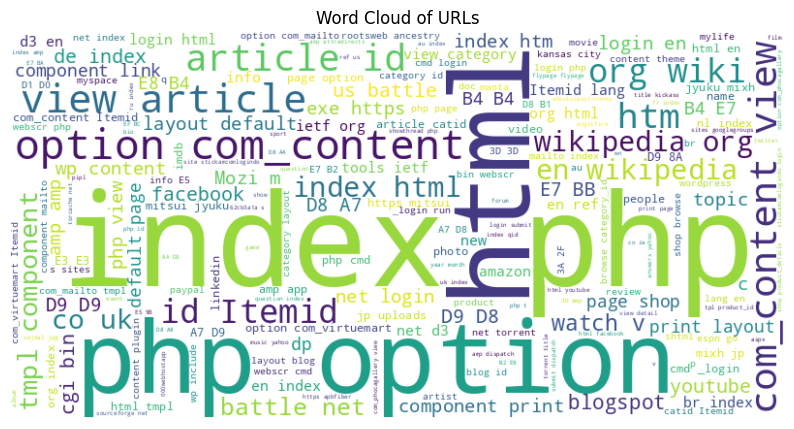

In [ ]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(urls_data['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [ ]:
# Histogram
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x=urls_data['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='plotly_dark',
    font=dict(color='white')
)

fig.show()

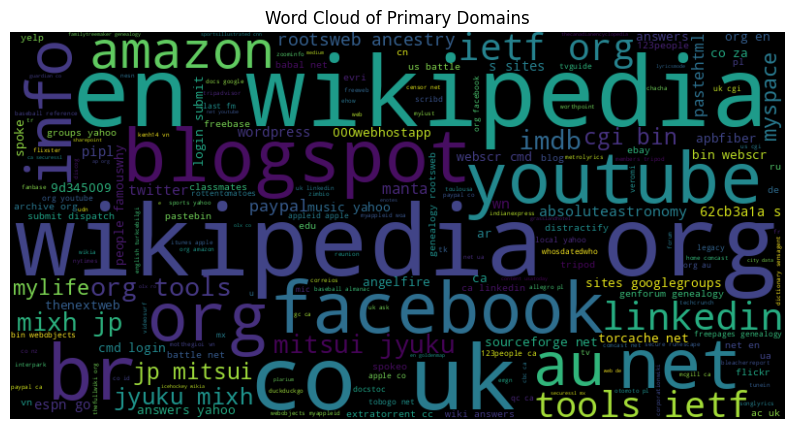

In [ ]:
filtered_domains = urls_data['pri_domain'].map(str).dropna()
text = ' '.join(filtered_domains)
wordcloud = WordCloud(background_color='black', colormap='viridis', width=800, height=400).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Primary Domains', color='black')
plt.show()

In [ ]:
# Creating a DataFrame with the sum of each column
counts = urls_data[['letters_count', 'digits_count', 'special_chars_count']].sum()

fig = go.Figure(data=[
    go.Bar(name='Letters', x=['Count'], y=[counts['letters_count']]),
    go.Bar(name='Digits', x=['Count'], y=[counts['digits_count']]),
    go.Bar(name='Special Characters', x=['Count'], y=[counts['special_chars_count']])
])

fig.update_layout(title='Counts of Letters, Digits, and Special Characters',
                  xaxis_title='Type',
                  yaxis_title='Count',
                  barmode='group',
                  template='plotly_dark',
                  font=dict(color='white'))

fig.show()

**Correlation Heatmap**

In [ ]:
numeric_data = urls_data.select_dtypes(include='number')
corr_matrix = numeric_data.corr()

heatmap = go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Oranges',
)

layout = go.Layout(
    title='Correlation Heatmap',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

fig = go.Figure(data=heatmap, layout=layout)
fig.show()


In [ ]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }

    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]

    return "Global"

In [ ]:
urls_data['url_region'] = urls_data['pri_domain'].apply(lambda x: get_url_region(str(x)))

In [ ]:
urls_data.head(20)

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,www.garage-pirenne.be,63,7,18,0,1,0,0,Belgium
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,Global
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0,118,buzzfil.net,93,1,24,0,1,0,0,Global
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0,45,espn.go.com,31,4,10,0,0,0,0,Global
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0,46,yourbittorrent.com,40,0,6,1,0,0,0,Global
8,http://www.pashminaonline.com/pure-pashminas,defacement,1,44,www.pashminaonline.com,37,0,7,0,1,0,0,Global
9,allmusic.com/album/crazy-from-the-heat-r16990,benign,0,45,allmusic.com,33,5,7,0,0,0,0,Global


In [ ]:
region_counts = urls_data['url_region'].value_counts()
if 'Global' not in region_counts.index:
    region_counts['Global'] = 0

data = pd.DataFrame({'region': region_counts.index, 'count': region_counts.values})
colorscale = 'YlOrRd'

fig = go.Figure(data=go.Choropleth(
    locations=data['region'],
    z=data['count'],
    locationmode='country names',
    colorscale=colorscale,
    autocolorscale=True,
    marker_line_color='white',
    colorbar_title='Count'
))

fig.update_layout(title_text='Distribution of URL Regions')
fig.show()

In [ ]:
def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [ ]:
urls_data['root_domain'] = urls_data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [ ]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,www.garage-pirenne.be,63,7,18,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [ ]:
urls_data.isnull().sum()

url                    0
type                   0
url_type               0
url_len                0
pri_domain             0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [ ]:
urls_data.shape

(651191, 14)

In [ ]:
urls_data.duplicated().sum()

10066

In [ ]:
urls_data.drop_duplicates(inplace=True)

In [ ]:
urls_data.columns

Index(['url', 'type', 'url_type', 'url_len', 'pri_domain', 'letters_count',
       'digits_count', 'special_chars_count', 'shortened', 'abnormal_url',
       'secure_http', 'have_ip', 'url_region', 'root_domain'],
      dtype='object')

In [ ]:
urls_data.head()

,url,type,url_type,url_len,pri_domain,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,13,0,3,0,0,0,0,Brazil,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,29,1,5,0,0,0,0,Global,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,25,1,5,0,0,0,0,Global,bopsecrets
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,www.garage-pirenne.be,63,7,18,0,1,0,0,Belgium,garage-pirenne
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [ ]:
#Dropping unwanted columns
data = urls_data.drop(columns=['url','type','pri_domain'])
data.head()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,Brazil,br-icloud
1,0,35,29,1,5,0,0,0,0,Global,mp3raid
2,0,31,25,1,5,0,0,0,0,Global,bopsecrets
3,1,88,63,7,18,0,1,0,0,Belgium,garage-pirenne
4,1,235,199,22,14,0,1,0,0,Global,adventure-nicaragua


In [ ]:
data['root_domain'].value_counts()

wikipedia                    13426
0                            12215
youtube                       8639
blogspot                      8468
facebook                      8362
                             ...  
celebritygirlfriend              1
aamcocentraliowa                 1
warsawhousing                    1
alkimosbeachearlylearning        1
xboxaddict                       1
Name: root_domain, Length: 147233, dtype: int64

In [ ]:
data = data[data['root_domain'] != '0']

In [ ]:
data['root_domain'].value_counts()

wikipedia                    13426
youtube                       8639
blogspot                      8468
facebook                      8362
yahoo                         5843
                             ...  
celebritygirlfriend              1
aamcocentraliowa                 1
warsawhousing                    1
alkimosbeachearlylearning        1
xboxaddict                       1
Name: root_domain, Length: 147232, dtype: int64

In [ ]:
len(data['root_domain'].value_counts())

147232

**Applying Hash Encoding**

In [ ]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [ ]:
data['root_domain'] = data['root_domain'].apply(hash_encode)

In [ ]:
data['url_region'] = data['url_region'].apply(hash_encode)

In [ ]:
data.head()

,url_type,url_len,letters_count,digits_count,special_chars_count,shortened,abnormal_url,secure_http,have_ip,url_region,root_domain
0,2,16,13,0,3,0,0,0,0,27739261,1310791
1,0,35,29,1,5,0,0,0,0,32604616,58335668
2,0,31,25,1,5,0,0,0,0,32604616,28611805
3,1,88,63,7,18,0,1,0,0,71484583,89045308
4,1,235,199,22,14,0,1,0,0,32604616,76838614


In [ ]:
data.shape

(628910, 11)

In [ ]:
data.isnull().sum()

url_type               0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
abnormal_url           0
secure_http            0
have_ip                0
url_region             0
root_domain            0
dtype: int64

In [ ]:
x = data.drop(columns=['url_type'])
y = data['url_type']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

<div style="background-color:blue; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:black;"> <b> 2. ML Model Creation </b></div>

In [ ]:
classifiers = [
    AdaBoostClassifier(random_state=42),
    LogisticRegression(random_state=42),
    ExtraTreesClassifier()

]

In [ ]:
results = []
for classifier in classifiers:
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    scores = cross_val_score(pipeline, x, y, cv=2, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=2)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y, y_pred, average='weighted')
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))

In [ ]:
x = data.drop(columns=['url_type'])
y = data['url_type']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [ ]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results.head()

,Classifier,Accuracy,Recall,Precision,F1-Score
2,ExtraTreesClassifier,0.806685,0.806685,0.729884,0.761691
0,AdaBoostClassifier,0.785815,0.785815,0.691444,0.732299
1,LogisticRegression,0.680617,0.680617,0.782623,0.551273


In [ ]:
pipeline = Pipeline([
        ('classifier', ExtraTreesClassifier())
    ])
pipeline.fit(x_train,y_train)

Pipeline(steps=[('classifier', ExtraTreesClassifier())])

In [ ]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94    128303
           1       0.92      0.97      0.94     28697
           2       0.71      0.62      0.66     28094
           3       0.89      0.76      0.82      3579

    accuracy                           0.90    188673
   macro avg       0.86      0.82      0.84    188673
weighted avg       0.90      0.90      0.90    188673



<div style="background-color:blue; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:black;"> <b> 3.Communicating The Results of a ML Models </b></div>

In [ ]:
fig = go.Figure(data=go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                fill_color='black',
                font=dict(color='white'),
                align='center'),
    cells=dict(values=[results['Classifier'], results['Accuracy'], results['Precision'],
                       results['Recall'], results['F1-Score']],
               fill_color='black',
               font=dict(color='white'),
               align='center')))

fig.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'))

fig.show()

**Testing the model**

Benign = 0,
Defacement = 1,
Phishing = 2,
Malware = 3

In [ ]:
url = "http://coratradecenter.ro/catalog-produse/category/15/instrumente-de-scris-si-corectura"
numerical_values = get_numerical_values(url)
print(pipeline.predict([list(numerical_values.values())]))

[1]


In [ ]:
url = "https://colab.research.google.com/drive/1H-Ef89GetQkSzjzo3wddl-_2xUGwNkAi#scrollTo=mw0fI-f1IIdw"
numerical_values = get_numerical_values(url)
print(pipeline.predict([list(numerical_values.values())]))

[0]


In [ ]:
url = "https://limit.user-87876kop9776zj7tt5hsjql5z17-ggq97zk821876t9u0opm.resolution-klpozjshbv716zgyqbbsn.sharetolink.net/f033ae0a859fd9a87a68e8574b4ae676/Web?885db116fdbfb21918z87HgO97YHhxa5120312838zXAZE7162361288097b5e0759ceebdda1fc2cd244e34288097b5e0759ceebdda1fc2cd244e34"
numerical_values = get_numerical_values(url)
print(pipeline.predict([list(numerical_values.values())]))

[2]


In [ ]:
url = "https://www.angelfire.com/goth/devilmaycrytonite/"
numerical_values = get_numerical_values(url)
print(pipeline.predict([list(numerical_values.values())]))

[3]


**CONCLUSION**

This project provides in depth analysis for detecting malicious URL's. We have used our model to work upon the URL's features and evaluate the performance using various metrics.

The notebook showcases the effectiveness of feature engineering, including extracting domain information, calculating URL length, examining special characters, and analyzing the presence of specific keywords or patterns. These features are used to train several classification models, including logistic regression, random forest, gradient boosting, and support vector machines.

The performance of the models is evaluated using metrics such as accuracy, precision, recall, and F1 score. The notebook demonstrates how to interpret these metrics and make informed decisions about the model's effectiveness in detecting malicious URLs.

Overall, the Malicious URL Detection notebook serves as a valuable resource for understanding and implementing machine learning techniques for identifying malicious URLs. It provides insights into feature engineering, model selection, and performance evaluation, which are crucial for building effective detection systems.

**Future Scope**

Taking mode data from other sources like Malware Domains, Kaggle, OpenPhish, etc.

New URL's are added every single day on PhishTank and PhishStorm. So, making the project live will help us in predicting the newly added URL's because Phishtank and PhishStorm takes voting review in order to categorize the website as phishing or Benign.

Indepth Analysis of distribution of data using more accurate map (statewise)

